In [53]:
######################################CONSTANTS######################################
METRIC = 'accuracy'
MODE = 'min'

RUNS = 100
LOG_FREQ = 100
threshold = 0.98  # threshold for x-axis cutoff


COLOR = {'non-active_no_prior': '#1f77b4',
         'ts_uniform': 'red',#'#ff7f0e',
         'ts_informed': 'green',
         'epsilon_greedy_no_prior': 'tab:pink',
         'bayesian_ucb_no_prior': 'cyan'

         }



METHOD_NAME_DICT = {'non-active_no_prior': 'Non-active',
                    #                         'non-active_uniform': 'non-active_uniform',
                    #                         'non-active_informed': 'non-active_informed',
                    'ts_uniform': 'TS',
                    'ts_informed': 'TS (informative)',
                    'epsilon_greedy_no_prior': 'Epsilon greedy',
                    'bayesian_ucb_no_prior': 'Bayesian UCB',

                    }
TOPK_METHOD_NAME_DICT = {'non-active_no_prior': 'Non-active',
                          #                         'non-active_uniform': 'non-active_uniform',
                          #                         'non-active_informed': 'non-active_informed',
                          'ts_uniform': 'MP-TS',
                          'ts_informed': 'MP-TS (informative)',
                          'epsilon_greedy_no_prior': 'Epsilon greedy',
                          'bayesian_ucb_no_prior': 'Bayesian UCB',
                          }

LINEWIDTH = 13.97


######################################CONSTANTS######################################
import sys

sys.path.insert(0, '..')
import argparse
from typing import Dict, Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from data_utils import DATASIZE_DICT, FIGURE_DIR, RESULTS_DIR
from data_utils import DATASET_NAMES, TOPK_DICT

import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

RESULTS_DIR = RESULTS_DIR + 'active_learning_topk/'



In [56]:
def plot_topk_accuracy(ax: mpl.axes.Axes,
                       experiment_name: str,
                       topk: int,
                       eval_metric: str,
                       pool_size: int,
                       threshold: float,
                       plot_informed: bool = False) -> None:
    
    if plot_informed:
        benchmark = 'ts_informed'
        method_list = {'ts_informed': 'TS (informative)',
                       'ts_uniform': 'TS (uninformative)', }
    else:
        benchmark = 'ts_uniform'
        method_list = {#'non-active_no_prior', 
                       'ts_uniform', 
                       'epsilon_greedy_no_prior', 
                       'bayesian_ucb_no_prior'}
        # method_list = {'non-active_no_prior', 'ts_uniform'}

    for method in method_list:
        metric_eval = np.load(
            RESULTS_DIR + experiment_name + ('%s_%s.npy' % (eval_metric, method))).mean(axis=0)
        x = np.arange(len(metric_eval)) * LOG_FREQ / pool_size
        if topk == 1:
            if plot_informed:
                label = method_list[method]
            else:
                label = METHOD_NAME_DICT[method]
        else:
            label = TOPK_METHOD_NAME_DICT[method]
        ax.plot(x, metric_eval, label=label, color=COLOR[method], linewidth=3)

        if method == benchmark:
            if method == benchmark:
                if max(metric_eval) > threshold:
                    cutoff = list(map(lambda i: i > threshold, metric_eval.tolist()[10:])).index(True) + 10
                    cutoff = min(int(cutoff * 1.2), len(metric_eval) - 1)
                else:
                    cutoff = len(metric_eval) - 1

    ax.set_xlim(0, cutoff * LOG_FREQ / pool_size)
    ax.set_ylim(0, 1.0)
    xmin, xmax = ax.get_xlim()
    step = ((xmax - xmin) / 4.0001)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax.xaxis.set_ticks(np.arange(xmin, xmax + 0.001, step))
    ax.yaxis.set_ticks(np.arange(0, 1.01, 0.20))
    ax.tick_params(pad=0.25, length=1.5)

    return ax


In [57]:
def main(eval_metric: str, top1: bool, pseudocount: int, threshold: float) -> None:
    fig, axes = plt.subplots(ncols=len(TOPK_DICT), dpi=300, sharey=True)
    idx = 0
    for dataset in TOPK_DICT:
        if top1:
            topk = 1
        else:
            topk = TOPK_DICT[dataset]
        experiment_name = '%s_%s_%s_top%d_runs%d_pseudocount%.2f/' % \
                          (dataset, METRIC, MODE, topk, RUNS, pseudocount)
        plot_topk_accuracy(axes[idx],
                           experiment_name,
                           topk,
                           eval_metric,
                           DATASIZE_DICT[dataset],
                           threshold=threshold)
        if topk == 1:
            axes[idx].set_title(DATASET_NAMES[dataset])
        else:
            axes[idx].set_xlabel("#queries")
        if idx > 0:
            axes[idx].tick_params(left=False)
        idx += 1

    axes[-1].legend()
    if topk == 1:
        axes[0].set_ylabel("MRR, top-1")
    else:
        axes[0].set_ylabel("MRR, top-m")

    fig.set_size_inches(LINEWIDTH, 2.5)
    fig.subplots_adjust(bottom=0.05, wspace=0.20)
    fig.tight_layout()

    if top1:
        figname = FIGURE_DIR + '%s_%s_%s_top1_pseudocount%d.pdf' % (METRIC, MODE, eval_metric, pseudocount)
    else:
        figname = FIGURE_DIR + '%s_%s_%s_topk_pseudocount%d.pdf' % (METRIC, MODE, eval_metric, pseudocount)
    fig.savefig(figname, bbox_inches='tight', pad_inches=0)


def main_informed(eval_metric: str, pseudocount: int, threshold: float) -> None:

    fig, axes = plt.subplots(ncols=5, nrows=1, dpi=300, sharey=True)
    for idx, dataset in enumerate(TOPK_DICT.keys()):
        experiment_name = '%s_%s_%s_top%d_runs%d_pseudocount%.2f/' % \
                          (dataset, METRIC, MODE, 1, RUNS, pseudocount)
        plot_topk_accuracy(axes[idx],
                           experiment_name,
                           1,
                           eval_metric,
                           DATASIZE_DICT[dataset],
                           threshold=threshold,
                           plot_informed=True)
        axes[-1].legend()
        axes[0].set_ylabel("MRR, top-1")
        axes[idx].set_xlabel("#queries")
        axes[idx].set_title(DATASET_NAMES[dataset])
    
    fig.set_size_inches(LINEWIDTH, 2.5)
    fig.subplots_adjust(wspace=0.20)
    fig.tight_layout()

    figname = FIGURE_DIR + 'informed_%s_%s_%s_pseudocount%d.pdf' % (METRIC, MODE, eval_metric, pseudocount)
    fig.savefig(figname, bbox_inches='tight', pad_inches=0)

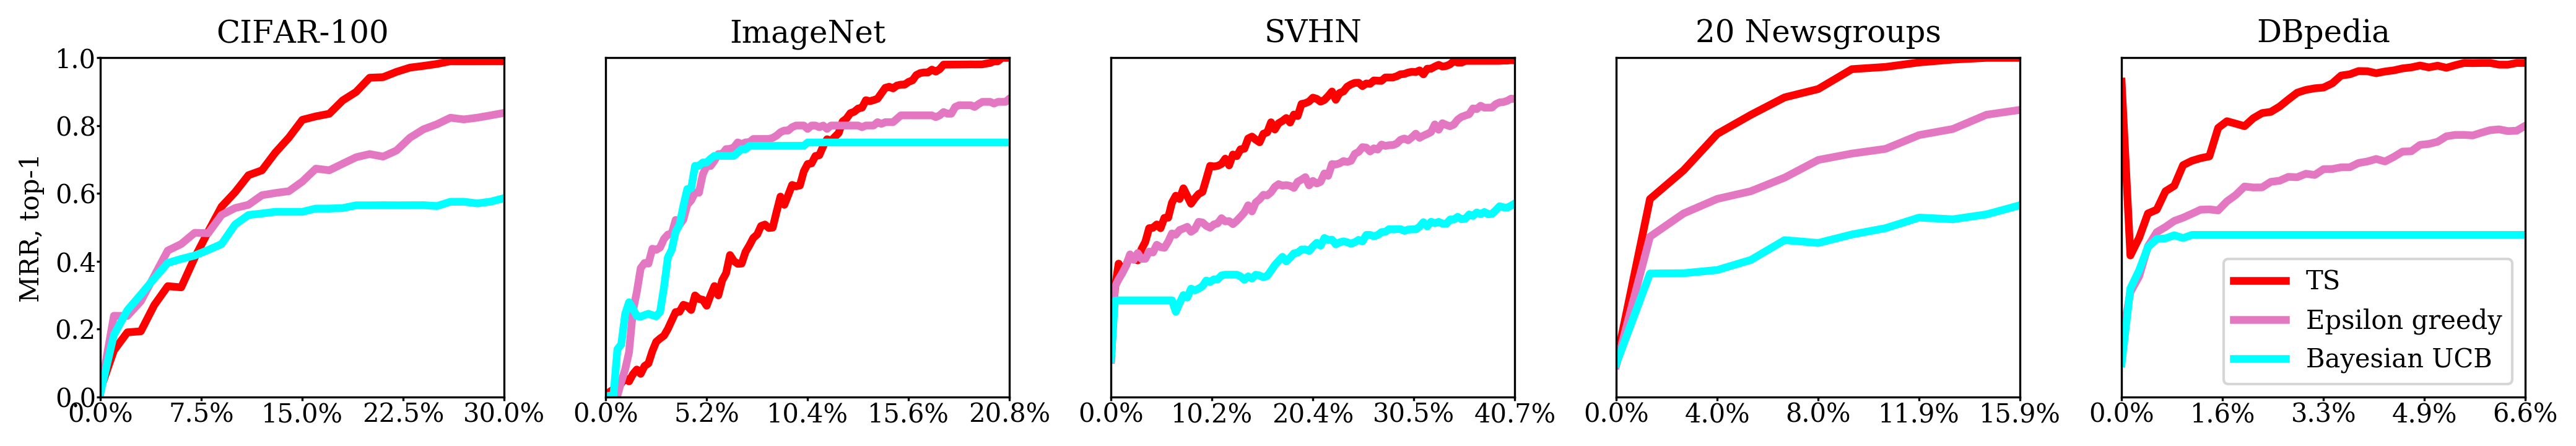

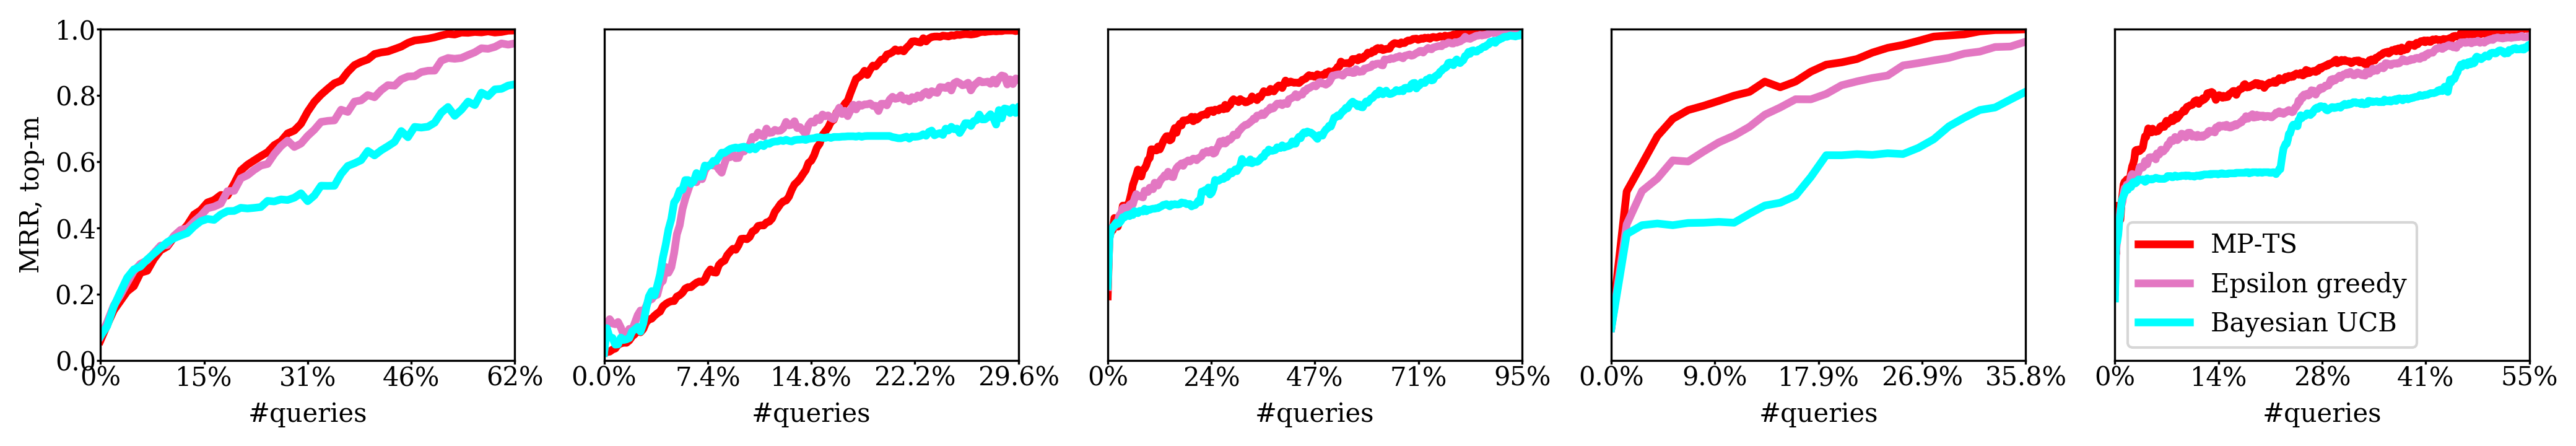

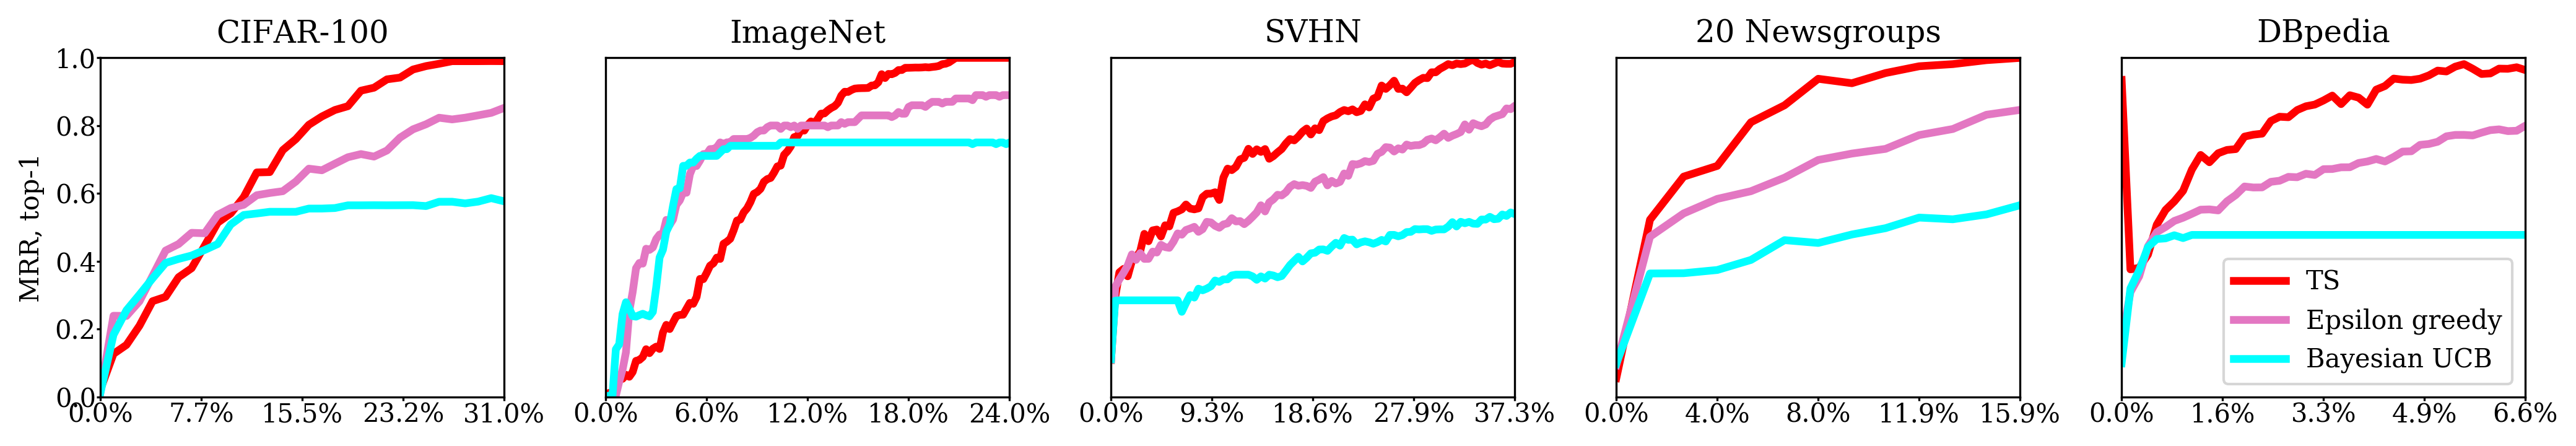

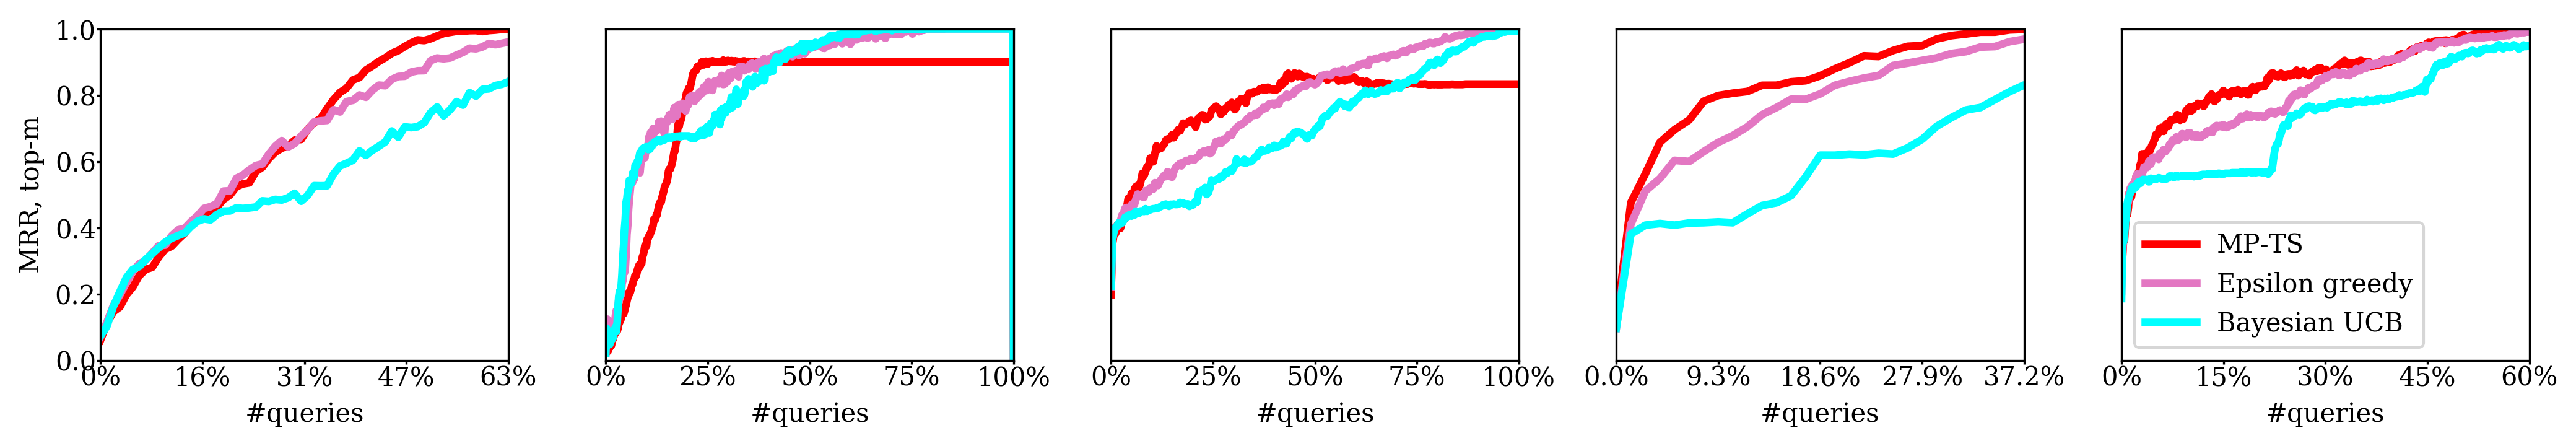

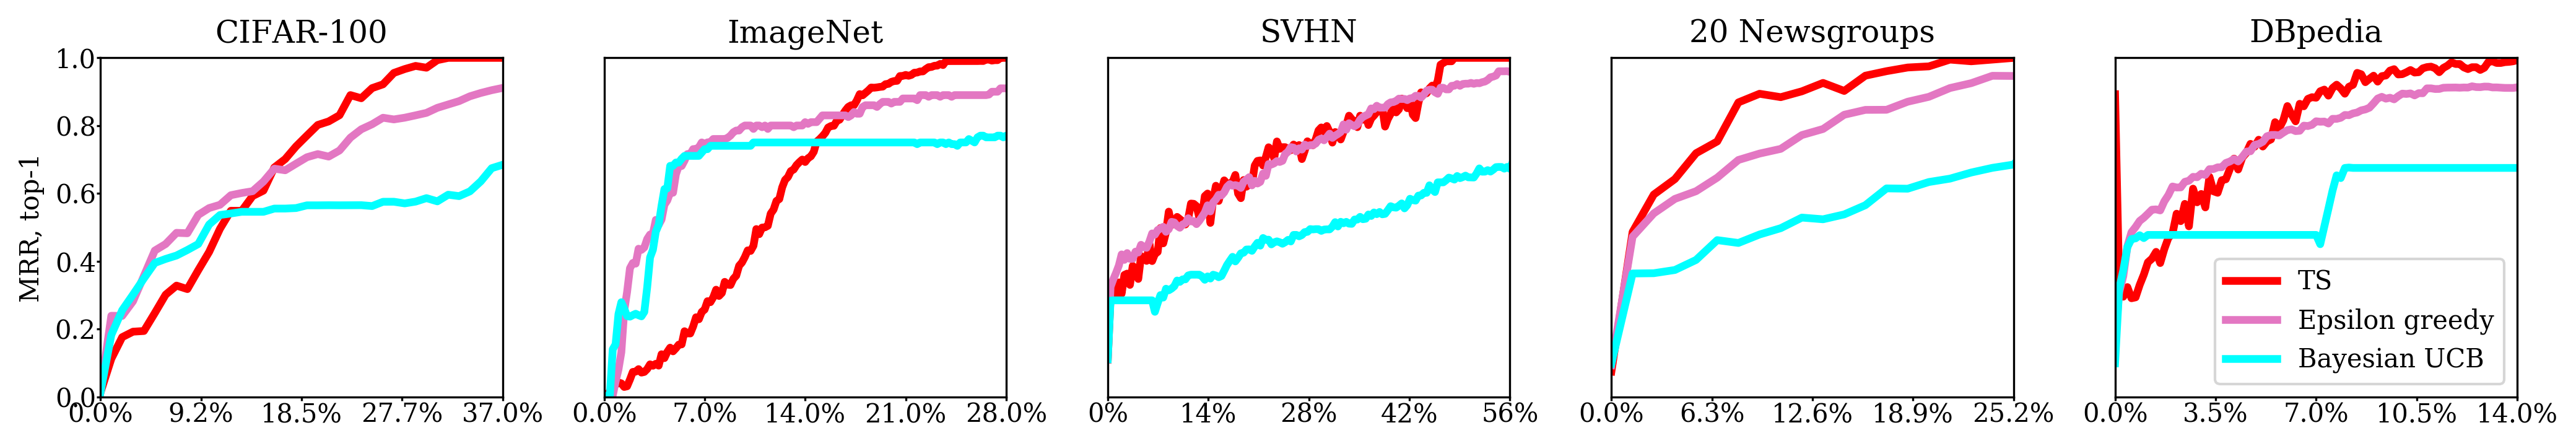

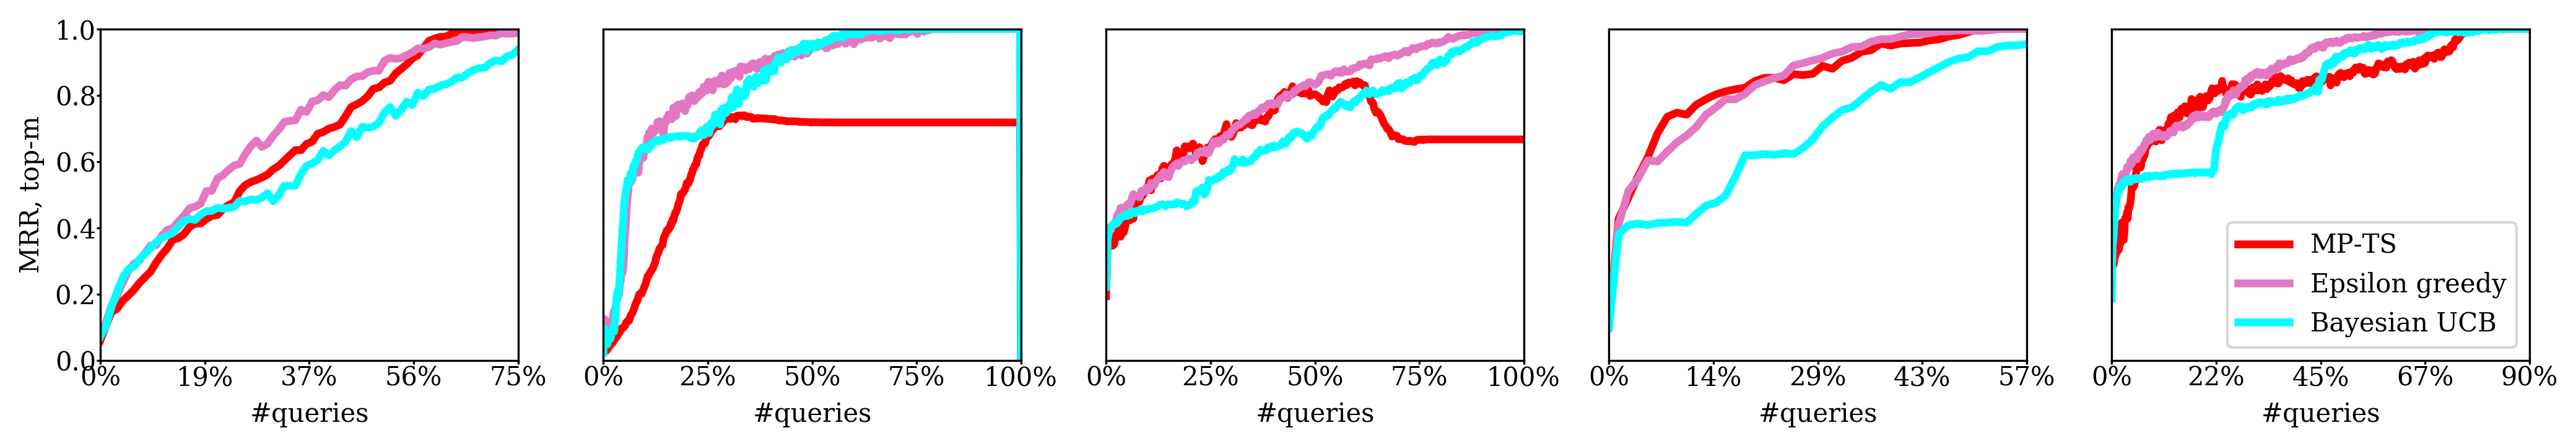

In [58]:
for pseudocount in [2, 10, 100]:
    for top1 in [True, False]:
        main('mrr', top1, pseudocount, threshold)
        # main_informed(eval_metric, pseudocount, threshold)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

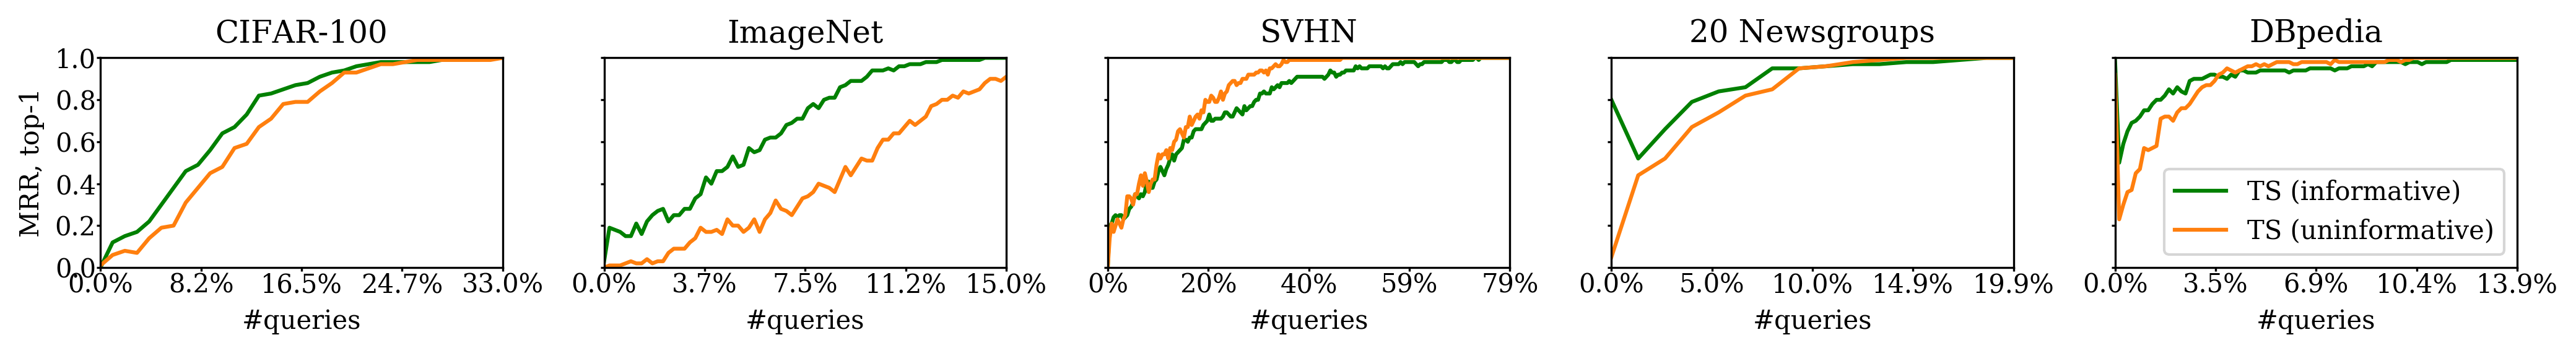

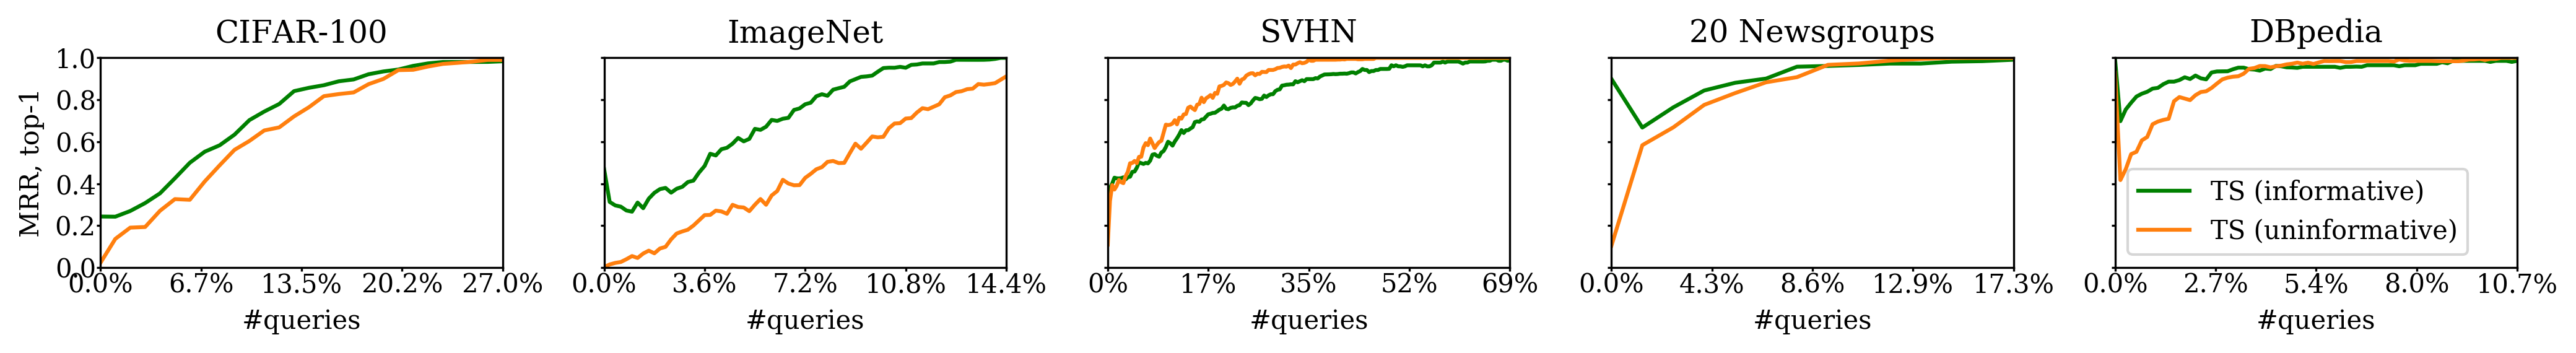

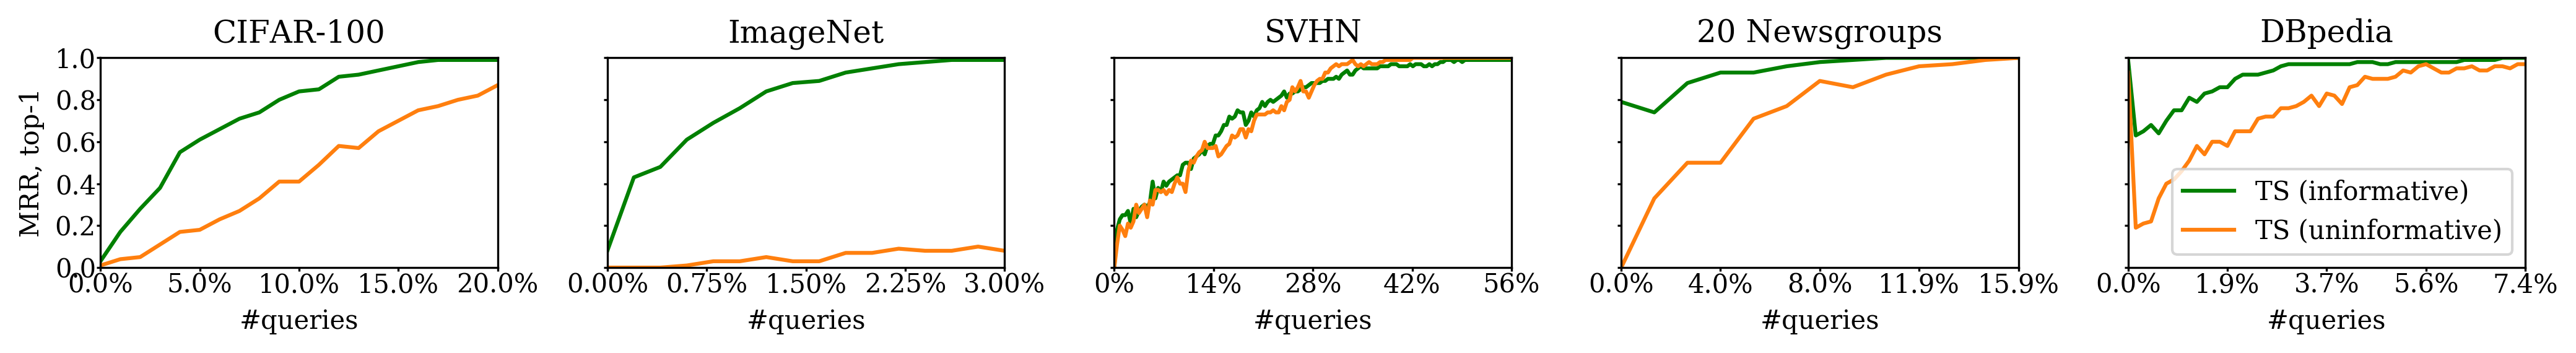

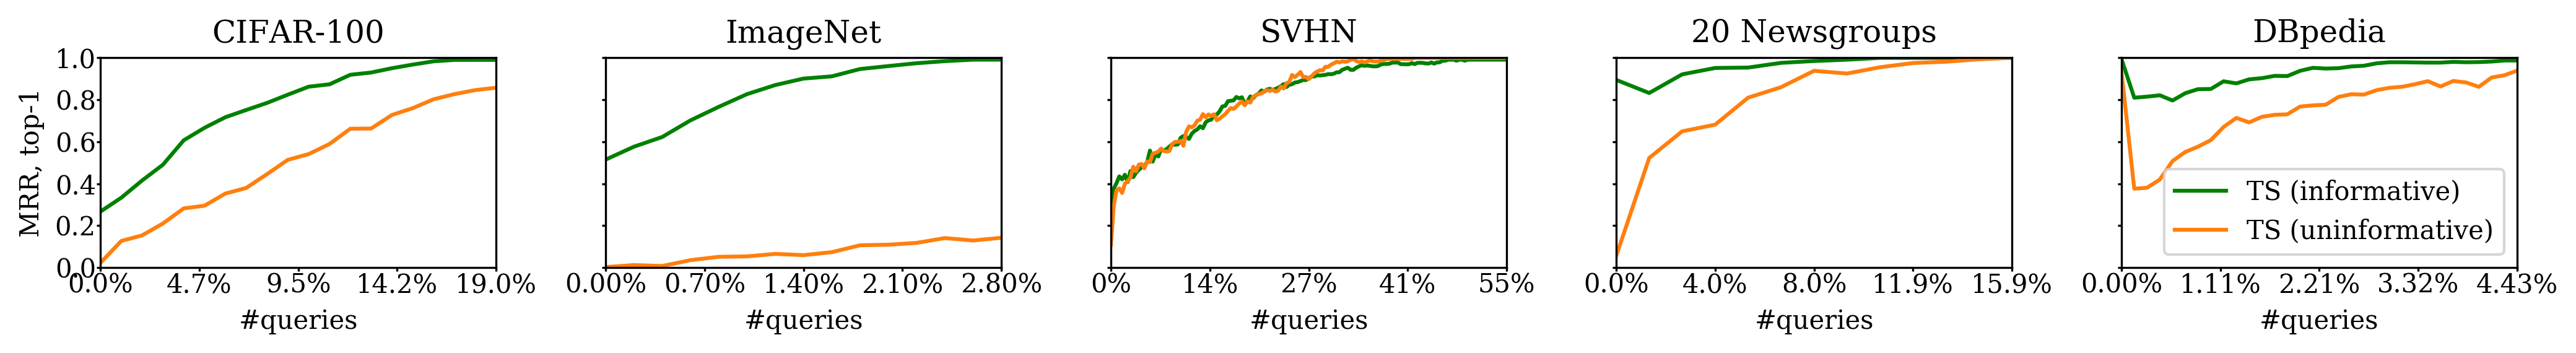

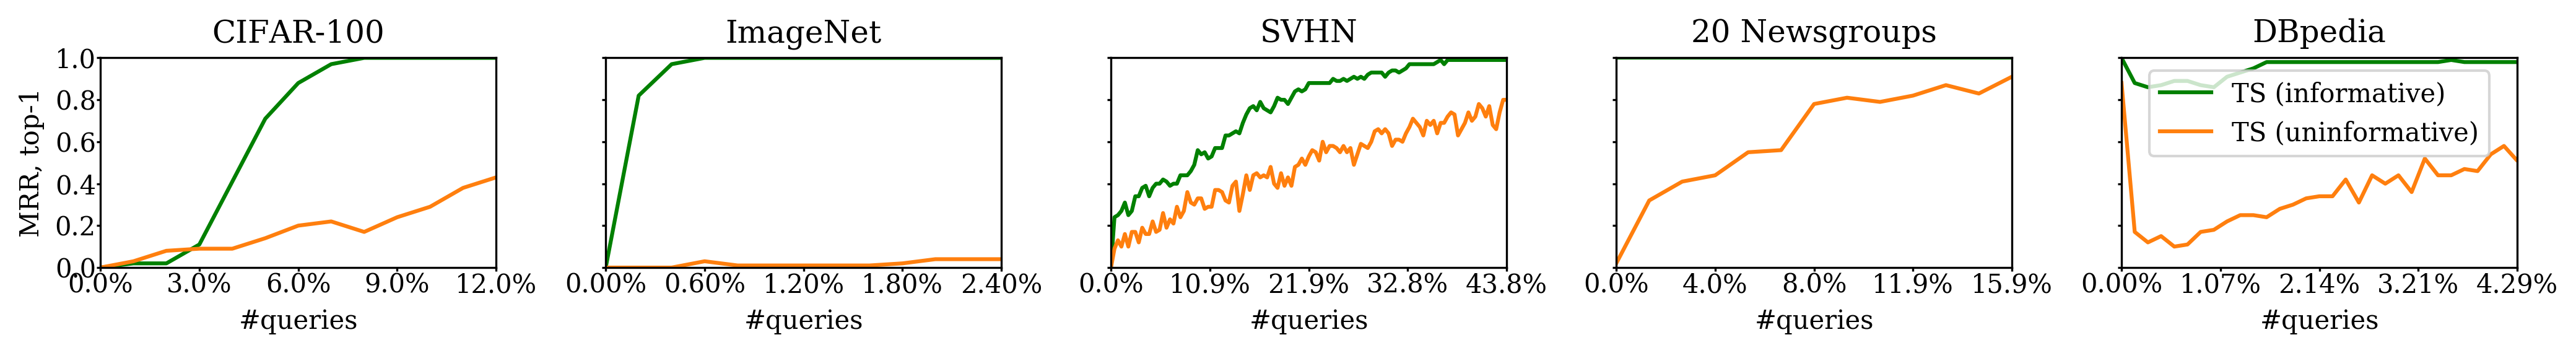

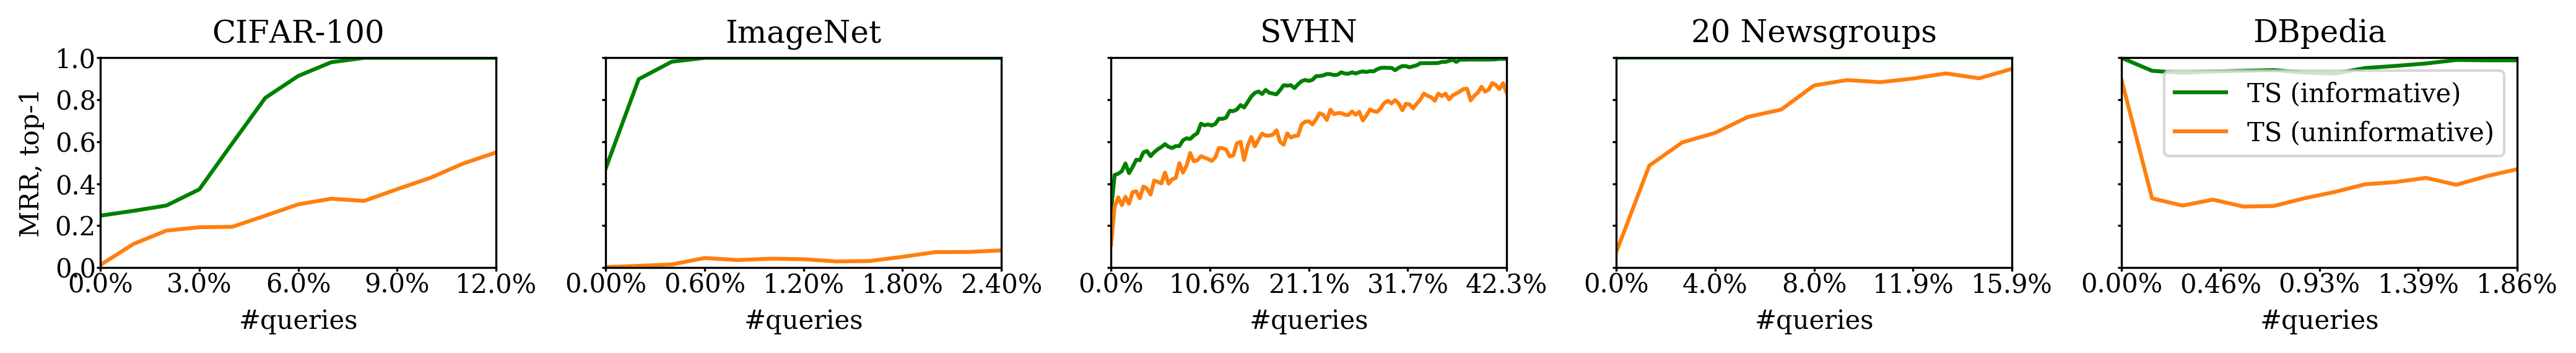

In [43]:
# for pseudocount in [2, 10, 100]:
#     for eval_metric in ['avg_num_agreement', 'mrr']:
#         main_informed(eval_metric, pseudocount, threshold)